## Memory constraint 

In [1]:
import tensorflow as tf
# tf.test.gpu_device_name()
# #Run on GPU
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
#Run on CPU
tf.config.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
# # Create some tensors and perform an operation
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# print(c)
# tf.debugging.set_log_device_placement(False)

2022-04-21 13:35:13.038112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-21 13:35:13.826207: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-21 13:35:13.826851: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-21 13:35:13.890824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro P620 computeCapability: 6.1
coreClock: 1.354GHz coreCount: 4 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 74.65GiB/s
2022-04-21 13:35:13.890874: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-21 13:35:13.894051: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-21 1

### Load & Prep data

In [2]:
import numpy as np
import random
import cv2
import os
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

X_train, y_train, X_test, y_test = load_dataset()

In [3]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

X_train , X_test = prep_pixels(X_train, X_test)

In [4]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


clients = create_clients(X_train, y_train, num_clients=10, initial='client')

#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))


2022-04-21 13:35:20.314307: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 13:35:20.314953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-04-21 13:35:20.314967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      
2022-04-21 13:35:20.314971: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


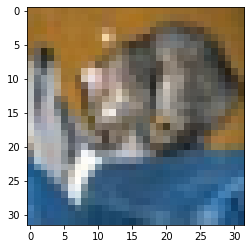

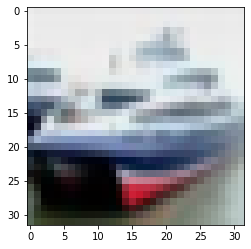

In [5]:
from matplotlib import pyplot as plt
for i in range(2):
    img = X_test[i].reshape((32,32,3))
    plt.imshow(img, cmap="Greys")
    plt.show()

## Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16

# from keras import Sequential
# from keras import applications

class SimpleMLP:
    @staticmethod
    def build(shape, classes,only_digits=True):
        base_model_1 = VGG16(include_top=False,input_shape=(32,32,3),classes=y_train.shape[1])
        model_1= Sequential()
        model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
        model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers
        #Add the Dense layers along with activation and batch normalization
        model_1.add(Dense(1024,activation=('relu'),input_dim=512))
        model_1.add(Dense(512,activation=('relu'))) 
        model_1.add(Dense(256,activation=('relu'))) 
        #model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
        model_1.add(Dense(128,activation=('relu')))
        #model_1.add(Dropout(.2))
        model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer
        return model_1

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(1 * weight[i])
    return weight
def scale_model_weights2(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(1 * weight[i])
    return weight_final


def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad
def test_model_mid(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    return acc, loss

def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('acc: {:.3%} | loss: {}'.format(acc, loss))
    return acc, loss

In [ ]:
tf.debugging.set_log_device_placement(False)
#On Full dataset
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(32)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(3072, 10) 
lr = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr , 
                momentum=0.9
               ) 
SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=20, verbose=1)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)


2022-04-21 13:36:05.264165: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2022-04-21 13:36:05.909538: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2022-04-21 13:36:06.199419: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/20


2022-04-21 13:36:06.830457: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-21 13:36:06.849956: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz


1563/1563 [==============================] - 664s 424ms/step - loss: 1.3679 - accuracy: 0.4996


2022-04-21 13:47:10.702459: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 2/20
1563/1563 [==============================] - 670s 428ms/step - loss: 0.5259 - accuracy: 0.8202


2022-04-21 13:58:20.471269: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 3/20
1563/1563 [==============================] - 664s 425ms/step - loss: 0.4070 - accuracy: 0.8619
Epoch 4/20
1563/1563 [==============================] - 659s 421ms/step - loss: 0.3393 - accuracy: 0.8832
Epoch 5/20
1563/1563 [==============================] - 659s 422ms/step - loss: 0.2986 - accuracy: 0.9001
Epoch 6/20
1563/1563 [==============================] - 662s 423ms/step - loss: 0.2637 - accuracy: 0.9116
Epoch 7/20
1563/1563 [==============================] - 661s 423ms/step - loss: 0.2402 - accuracy: 0.9209
Epoch 8/20
1563/1563 [==============================] - 659s 422ms/step - loss: 0.2090 - accuracy: 0.9332
Epoch 9/20
1563/1563 [==============================] - 659s 421ms/step - loss: 0.1940 - accuracy: 0.9381
Epoch 10/20
1563/1563 [==============================] - 659s 422ms/step - loss: 0.1731 - accuracy: 0.9456
Epoch 11/20
1563/1563 [==============================] - 681s 436ms/step - loss: 0.1592 - accuracy: 0.9516
Epoch 12/20
 996/1563 [==================>..

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
#create optimizer
comms_round = 10
lr = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 
smlp_global = SimpleMLP()

global_model = smlp_global.build(3072, 10)
global_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)
global_model.build(input_shape=(None,32,32,3))

average_weights=global_model.get_weights()
average_weights = np.array(average_weights)

average_weights.fill(0)
ranking_acc_comp=list() 

for comm_round in range(comms_round):
    average_weights = np.array(average_weights)
    average_weights.fill(0)
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    ranking_acc=list()
    ranking_acc.clear()
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(3072, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.build(input_shape=(None,32,32,3))
        local_model.set_weights(global_model.get_weights())
        local_model.fit(clients_batched[client], epochs=2, verbose=1)
        weights=local_model.get_weights();
        weights = np.array(weights)
        average_weights=np.add(average_weights,weights)
        
        for(X_test, Y_test) in test_batched:
         local_acc, local_loss = test_model(X_test, Y_test, local_model, comm_round)
        ranking_acc.append(local_acc)
 
        K.clear_session()
    average_weights=average_weights/10
    average_weights = average_weights.tolist()
    
    ranking_acc.sort(reverse=True)
    temp=0
    avg=0
    for i in range(comm_round+1):
      avg+=ranking_acc[i]
    avg=avg/(comm_round+1)
    ranking_acc_comp.append(avg)


    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

In [ ]:
print(ranking_acc_comp)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ranking_acc_comp)
plt.show()


In [ ]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=2, verbose=0)
 
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)

#gpu sensitive

In [ ]:
!pip install matplotlib #Keras #opencv-python